Kiel Brunner | 
Lab 1 |
IST718

In [0]:
import pandas as pd 
import numpy as np 
from scipy.stats import uniform 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
import seaborn as sns
import requests
import bs4
from bs4 import BeautifulSoup
import urllib.request
from IPython.display import HTML
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import fuzzymatcher
import fuzzy_pandas as fpd


## Data Acquisition, Inspection and Cleaning




Load the 'Coaches9.csv' file and inspect the information. 

In [10]:
from google.colab import files
uploaded = files.upload()

Saving Coaches9.csv to Coaches9.csv


Call in the data and inspect it to assess changes that need to be made. Remove the 'SchoolPay' column and use the 'TotalPay' column for analysis and prediction, as they would be predictors for eachother and build a useless model. 

In [11]:
Coaches = pd.read_csv("Coaches9.csv")

print(pd.DataFrame.head(Coaches))
##Inspect data
#Coaches.describe()

##Inspect column variable types
#Coaches.dtypes

##Remove duplicative variable
del Coaches['SchoolPay']
##Change variable to lowercase
Coaches['School'] =Coaches['School'].str.lower()

                  School Conference  ... AssistantPay        Buyout
0              Air Force   Mt. West  ...          $0             --
1                  Akron        MAC  ...          $0      $688,500 
2                Alabama        SEC  ...          $0   $33,600,000 
3  Alabama at Birmingham      C-USA  ...          $0    $3,847,500 
4      Appalachian State   Sun Belt  ...          $0    $2,160,417 

[5 rows x 9 columns]


School          object
Conference      object
Coach           object
TotalPay        object
Bonus           object
BonusPaid       object
AssistantPay    object
Buyout          object
dtype: object

Find the location of missing values for 'TotalPay' to track them down and add to their respective current estimated or actual salary.

In [0]:
##Replace missing values
#Coaches.index[Coaches['TotalPay']=='--']
#Coaches.iloc[12]
#Coaches.iloc[16]
#Coaches.iloc[91]
#Coaches.iloc[99]
Coaches.at[12,'TotalPay'] = '4100000'
Coaches.at[16,'TotalPay'] = '1500000'
Coaches.at[91,'TotalPay'] = '1500000'
Coaches.at[99,'TotalPay'] = '700000'
#Coaches['TotalPay'].value_counts()

Convert 'TotalPay' into an integer. 

In [0]:
#Convert variable type
Coaches['TotalPay'] = Coaches['TotalPay'].astype(str)
Coaches['TotalPay'] = Coaches['TotalPay'].replace({'\$': '', ',': ''}, regex=True)
Coaches['TotalPay'] = Coaches['TotalPay'].astype(int)
#Coaches.dtypes

In [0]:
##Inspect variable to assess matching capacity
#Coaches['Conference'].value_counts()

Scrape Endownment amount in Billions by Public and Private schools from wikipedia. 


In [0]:
from pandas.io.html import read_html
endow_page = 'https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_the_United_States_by_endowment'
wikitables_endow = read_html(endow_page, index_col=0, attrs={"class":"wikitable sortable"})

#print(wikitables[1])
NCAA_Endowment_public = wikitables_endow[1]
NCAA_Endowment_private = wikitables_endow[0]
#NCAA_Endowment_private.head()
#NCAA_Endowment_public.head()
NCAA_Endowment = pd.concat([NCAA_Endowment_public, NCAA_Endowment_private], ignore_index=False, axis=0)
#NCAA_Endowment = pd.concat(NCAA_Endoment_pieces)
NCAA_Endowment = NCAA_Endowment[['2018(billions USD)[3]']]
NCAA_Endowment = NCAA_Endowment.reset_index()
NCAA_Endowment = NCAA_Endowment.rename(columns={"Institution": "School"})
NCAA_Endowment['School'] =NCAA_Endowment['School'].str.lower()

NCAA_Endowment['School'] = NCAA_Endowment['School'].str.replace(r"([\(\[]).*?([\)\]])", "\g<1>\g<2>")
NCAA_Endowment['School'] = NCAA_Endowment['School'].str.replace(r"([\(\[]).*?([\)\]])", "")
NCAA_Endowment['School'] = NCAA_Endowment['School'].str.replace(r"university", " ")

#NCAA_Endowment

Import and clean conference table with nicknames to append to other tables and improve joins. 

In [0]:
con_page = 'https://en.wikipedia.org/wiki/NCAA_Division_I_Football_Bowl_Subdivision'
wikitables_con = read_html(con_page, index_col=0, attrs={"class":"wikitable sortable"})

#print(wikitables_con[0])
NCAA_Conference = wikitables_con[0]
NCAA_Conference = NCAA_Conference.reset_index()

NCAA_Conference = NCAA_Conference[['Conference','Nickname']]
NCAA_Conference.at[5,'Nickname'] = 'Independent'
NCAA_Conference.at[7,'Nickname'] = 'MT. West'

NCAA_Conference['Conference'] = NCAA_Conference['Conference'].str.replace(r"([\(\[]).*?([\)\]])", "\g<1>\g<2>")
NCAA_Conference['Conference'] = NCAA_Conference['Conference'].str.replace(r"([\(\[]).*?([\)\]])", "", regex=True)
NCAA_Conference['Conference'] = NCAA_Conference['Conference'].str.replace(r"Conference", " ")
NCAA_Conference['Conference'] = NCAA_Conference['Conference'].replace({'†': ''}, regex=True)

NCAA_Conference['Nickname'] = NCAA_Conference['Nickname'].str.replace(r"([\(\[]).*?([\)\]])", "\g<1>\g<2>")
NCAA_Conference['Nickname'] = NCAA_Conference['Nickname'].str.replace(r"([\(\[]).*?([\)\]])", "", regex=True)
NCAA_Conference['Nickname'] = NCAA_Conference['Nickname'].replace({'†': ''}, regex=True)

#NCAA_Conference

Import and clean stadium information. 

In [0]:
page = 'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_stadiums'
wikitables_stadium = read_html(page, index_col=0, attrs={"class":"wikitable sortable"})

NCAA_Stadium = wikitables_stadium[0]

NCAA_Stadium = NCAA_Stadium.reset_index()
NCAA_Stadium = NCAA_Stadium.rename(columns={"Team": "School"})
NCAA_Stadium['School'] = NCAA_Stadium['School'].astype(str)
NCAA_Stadium['School'] =NCAA_Stadium['School'].str.lower()
NCAA_Stadium = NCAA_Stadium[['Stadium','School','Conference','Capacity','State']]
NCAA_Stadium = pd.DataFrame(NCAA_Stadium)
NCAA_Stadium['Capacity'] = NCAA_Stadium['Capacity'].str.replace(r"([\(\[]).*?([\)\]])", "\g<1>\g<2>")
NCAA_Stadium['Capacity'] = NCAA_Stadium['Capacity'].str.replace(r"([\(\[]).*?([\)\]])", "")
NCAA_Stadium['Capacity'] = NCAA_Stadium['Capacity'].replace({'\$': '', ',': ''}, regex=True)
NCAA_Stadium['Capacity'] = NCAA_Stadium['Capacity'].astype(int)
#NCAA_Stadium

Import additional FBS info to improve joins.

In [0]:
con_page = 'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs'
wikitables_fbs = read_html(con_page, index_col=0, attrs={"class":"wikitable sortable"})

#print(wikitables_fbs[0])
NCAA_fbs = pd.DataFrame(wikitables_fbs[0])

NCAA_fbs = NCAA_fbs.reset_index()
NCAA_fbs = NCAA_fbs[['Team','Nickname','CurrentConference','Enrollment']]
NCAA_fbs['Team'] =NCAA_fbs['Team'].str.lower()

#NCAA_fbs

Import Win/Loss record table with the following columns:

Win-Loss Record: The number of wins, losses, and ties
Win %: The percentage of time the team won
MOV: The average margin of victory (negative in losses)
ATS +/-: The average amount of points that the team covers the spread by

In [0]:
page = 'https://www.teamrankings.com/ncf/trends/win_trends/'
wikitable_records = read_html(page, index_col=0, attrs={"class":"tr-table"})
wikitable_records[0]

record = pd.DataFrame(wikitable_records[0])
record = record.reset_index()
#record

Attempts to pull down the FSR and GSR information were blocked by a bot blocker. 

In [0]:
#import re
#import mechanize

#br = mechanize.Browser()
#br.set_handle_robots(False)
#br.set_handle_equiv(False) 
#br.open("https://web3.ncaa.org/aprsearch/gsrsearch/")

In order to retrieve the FGR and GSR report that was blocked, I used the old fashion way of creating a file manually. 

In [20]:
from google.colab import files
uploaded = files.upload()

Saving FGR_GSR_report.xlsx to FGR_GSR_report.xlsx


In [0]:
FGR_GSR_report = pd.read_excel("FGR_GSR_report.xlsx")

FGR_GSR_report['School'] =FGR_GSR_report['School'].str.lower()

FGR_GSR_report =FGR_GSR_report[['School', 'Conference','State','GSR','FGR']]
FGR_GSR_report['Conference'] = FGR_GSR_report['Conference'].str.replace(r"Conference", " ")
FGR_GSR_report['School'] = FGR_GSR_report['School'].str.replace(r"university", " ")

#FGR_GSR_report['Conference'].value_counts()
#FGR_GSR_report

##Join Section

Join fbs to conference info.

In [0]:
left_on = ["CurrentConference"] 
right_on = ["Nickname"]

fbs_con = fuzzymatcher.fuzzy_left_join(NCAA_fbs,NCAA_Conference, left_on, right_on)
fbs_con = pd.DataFrame(fbs_con)
fbs_con = fbs_con.sort_values(by='best_match_score', ascending = False)
fbs_con = pd.DataFrame(fbs_con)
fbs_con = fbs_con.reset_index()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
 #   print(report_stadium_coaches_endow_fbs)

fbs_con = fbs_con[['Team','Nickname_left','CurrentConference','Enrollment','Conference','Nickname_right']]
#fbs_con

Join fbs and conference infromation to graduation report.

In [0]:
left_on = ["Conference"] 
right_on = ["Conference"]


Report_Con = fuzzymatcher.fuzzy_left_join(FGR_GSR_report,NCAA_Conference, left_on, right_on)
Report_Con = pd.DataFrame(Report_Con)
Report_Con = Report_Con.sort_values(by='best_match_score', ascending = False)
Report_Con = pd.DataFrame(Report_Con)
Report_Con = Report_Con[Report_Con['best_match_score'] >-0.0024]
Report_Con = Report_Con.reset_index()

Report_Con = Report_Con[['School','Conference_left','State','GSR','FGR','Nickname']]

#Report_Con = Report_Con.dropna()
#Report_Con

Join fbs_con to report_con

In [0]:
right_on = ["School"] 
left_on = ["Team"]

fbs_con_report = fuzzymatcher.fuzzy_left_join(fbs_con,Report_Con, left_on, right_on)
fbs_con_report = pd.DataFrame(fbs_con_report)
fbs_con_report = fbs_con_report.sort_values(by='best_match_score', ascending = False)
fbs_con_report = pd.DataFrame(fbs_con_report)
fbs_con_report = fbs_con_report.reset_index()
fbs_con_report = fbs_con_report.dropna()
#fbs_con_report = fbs_con_report[fbs_con_report['best_match_score'] >0.12]
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
 #   print(report_stadium_coaches_endow_fbs)

fbs_con_report = fbs_con_report[['Team',	'Nickname_left',	'CurrentConference',	'Enrollment',	'Conference',	'Nickname_right',	'School',	'Conference_left',	'State',	'GSR',	'FGR',	'Nickname']]
#fbs_con_report

Join report with conference nickname to stadium list.

In [0]:
left_on = ["Team"] 
right_on = ["School"]

fbs_con_report_stadium = fuzzymatcher.fuzzy_left_join(fbs_con_report, NCAA_Stadium , left_on, right_on,)
fbs_con_report_stadium = pd.DataFrame(fbs_con_report_stadium)
fbs_con_report_stadium = fbs_con_report_stadium.sort_values(by='best_match_score', ascending = False) 
fbs_con_report_stadium = fbs_con_report_stadium.reset_index()
fbs_con_report_stadium = pd.DataFrame(fbs_con_report_stadium)
fbs_con_report_stadium = fbs_con_report_stadium[['Team','Nickname_left','CurrentConference','Enrollment','Conference_right','Nickname_right','School_left','State_left','GSR','FGR','Stadium','Capacity']]
fbs_con_report_stadium = fbs_con_report_stadium.dropna()
#fbs_con_report_stadium

Join the coaches file to the stadium and graduation report with the nickname and use nickname to improve match. 

In [0]:
left_on = ["School_left"] 
right_on = ["School"]

fbs_con_report_stadium_coaches = fuzzymatcher.fuzzy_left_join(fbs_con_report_stadium, Coaches , left_on, right_on,)
fbs_con_report_stadium_coaches = fbs_con_report_stadium_coaches.reset_index()
fbs_con_report_stadium_coaches = pd.DataFrame(fbs_con_report_stadium_coaches)
fbs_con_report_stadium_coaches = fbs_con_report_stadium_coaches.sort_values(by='best_match_score', ascending = False) 

fbs_con_report_stadium_coaches = fbs_con_report_stadium_coaches[fbs_con_report_stadium_coaches['best_match_score'] >0]
fbs_con_report_stadium_coaches = fbs_con_report_stadium_coaches[['Team',	'Nickname_left',	'CurrentConference',	'Enrollment',	'Conference_right',	'Nickname_right',	'School_left',	'State_left',	'GSR',	'FGR',	'Stadium',	'Capacity',	'School',	'Conference',	'Coach',	'TotalPay',	'Bonus',	'BonusPaid','Buyout']]
fbs_con_report_stadium_coaches = fbs_con_report_stadium_coaches.dropna()
#report_stadium_coaches['School_left'] = report_stadium_coaches['School_left'].str.replace(r"university", " ")

fbs_con_report_stadium_coaches
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
 #   print(report_stadium_coaches)
#report_stadium_coaches['School_left'].value_counts()

Join endowment list to coaches, stadium and graduation report. This order produced the highest match rate after words like 'Conference' and 'University' were removed. 

In [0]:
left_on = ["School_left"] 
right_on = ["School"]

fbs_con_report_stadium_coaches_endow = fuzzymatcher.fuzzy_left_join(fbs_con_report_stadium_coaches,NCAA_Endowment, left_on, right_on)
fbs_con_report_stadium_coaches_endow = pd.DataFrame(fbs_con_report_stadium_coaches_endow)
fbs_con_report_stadium_coaches_endow = fbs_con_report_stadium_coaches_endow.sort_values(by='best_match_score', ascending = False)
fbs_con_report_stadium_coaches_endow = pd.DataFrame(fbs_con_report_stadium_coaches_endow)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
 #   print(report_stadium_endow)
#fbs_con_report_stadium_coaches_endow

Find and input the few missing endowment variables. These variables were missing from the list because the original list only counted those schools with an endowment of one billion dollars or more. 

In [0]:
##Replace missing values
fbs_con_report_stadium_coaches_endow = fbs_con_report_stadium_coaches_endow[['Team',	'Nickname_left',	'CurrentConference',	'Enrollment',	'Conference_right',	'Nickname_right',		'State_left',	'GSR',	'FGR',	'Stadium',	'Capacity',	'Conference',	'Coach',	'TotalPay',	'Bonus',	'BonusPaid',	'Buyout',	'School_right',	'2018(billions USD)[3]']]

#report_stadium_coaches_endow.dtypes
#fbs_con_report_stadium_coaches_endow.index[fbs_con_report_stadium_coaches_endow['2018(billions USD)[3]'].isna()]
#report_stadium_coaches_endow.loc[80]
#report_stadium_coaches_endow.loc[445]
#report_stadium_coaches_endow.loc[457]
#report_stadium_coaches_endow.loc[458]
#report_stadium_coaches_endow.loc[463]
fbs_con_report_stadium_coaches_endow.at[80,'2018(billions USD)[3]'] = '$0.240'
fbs_con_report_stadium_coaches_endow.at[445,'2018(billions USD)[3]'] = '$0.129'
fbs_con_report_stadium_coaches_endow.at[457,'2018(billions USD)[3]'] = '$0.742'
fbs_con_report_stadium_coaches_endow.at[458,'2018(billions USD)[3]'] = '$0.778'
fbs_con_report_stadium_coaches_endow.at[463,'2018(billions USD)[3]'] = '$0.104'
#fbs_con_report_stadium_coaches_endow

Join record data.

In [0]:
left_on = ["Team"] 
right_on = ["Team"]

fbs_record = fuzzymatcher.fuzzy_left_join(NCAA_fbs,record, left_on, right_on)
fbs_record = pd.DataFrame(fbs_record)
fbs_record = fbs_record.sort_values(by='best_match_score', ascending = False)
fbs_record = fbs_record.reset_index()
fbs_record = fbs_record.dropna()
fbs_record = fbs_record[fbs_record['best_match_score']>0]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
 #   print(report_stadium_coaches_endow_fbs)

fbs_record = fbs_record[['Team_left',	'Nickname',	'CurrentConference',	'Enrollment',	'Team_right',	'Win-Loss Record',	'Win %',	'MOV',	'ATS +/-']]
#fbs_record

In [419]:
left_on = ["Team","Nickname_left"] 
right_on = ["Team_left","Nickname"]

all_join = fuzzymatcher.fuzzy_left_join(fbs_con_report_stadium_coaches_endow,fbs_record  , left_on, right_on,)
all_join = pd.DataFrame(record_con)
all_join = all_join.sort_values(by='best_match_score', ascending = False) 
all_join = all_join.reset_index()
all_join = record_con[['Team','Nickname_left','Enrollment_left','State_left','GSR','FGR','Capacity','Conference','Coach','TotalPay','Bonus','BonusPaid','Buyout','2018(billions USD)[3]','Win-Loss Record',	'Win %',	'MOV',	'ATS +/-']]
all_join.Conference.value_counts()

Sun Belt    14
MAC         13
SEC         12
Mt. West    11
ACC         11
C-USA        9
Big Ten      9
Pac-12       9
Big 12       8
AAC          7
Name: Conference, dtype: int64

The final dataframe to be utilized in the modeling exercise included 103 rows after adding individual missing values, carefully trimming bad matches by incrementally setting best match threshold levels, cutting certain words as mentioned previously and ordering the joins specifically to increase the likelyhood of a successful join. 

In [392]:
Coaches_Model = all_join

Coaches_Model.reset_index
Coaches_Model.TotalPay.describe

<bound method NDFrame.describe of 38     6603600.0
2      1831580.0
0      3000000.0
62     1425000.0
123     390000.0
         ...    
24     4700000.0
68      700000.0
73      700000.0
78      712500.0
108    1102500.0
Name: TotalPay, Length: 103, dtype: float64>

## Analysis and Modeling Section

In [420]:
Coaches_Model.describe()

,Enrollment,GSR,FGR,Capacity,TotalPay,Endowment,Win_Percent,MOV,Spread,runiform
count,103.000000,103.000000,103.000000,103.000000,1.030000e+02,102.000000,103.000000,103.000000,103.000000,103.000000
mean,29584.466019,78.941748,62.669903,51601.009709,2.409998e+06,4.388941,52.897087,2.761165,-0.349515,0.519488
std,12969.918116,9.214040,11.579553,23548.909476,1.993115e+06,5.178093,21.781965,11.368888,4.203544,0.289661
min,4300.000000,54.000000,31.000000,20000.000000,3.900000e+05,0.104000,0.000000,-25.800000,-11.600000,0.013310
25%,21550.000000,73.000000,56.000000,30372.500000,7.062500e+05,1.295000,33.300000,-3.950000,-3.600000,0.274079
50%,27800.000000,78.000000,63.000000,47825.000000,1.800000e+06,1.735000,53.800000,0.200000,-0.100000,0.523862
75%,38200.000000,86.000000,69.000000,62548.500000,3.661875e+06,5.544000,69.200000,11.000000,2.450000,0.764060
max,69400.000000,100.000000,93.000000,107601.000000,8.307000e+06,30.886000,93.300000,33.100000,10.800000,0.993929


In [393]:
Coaches_Model = Coaches_Model.rename(columns={"Nickname_left":"Nickname","Enrollment_left":"Enrollment","State_left":"State","2018(billions USD)[3]":"Endowment","Win-Loss Record":"Record","Win %":"Win_Percent","ATS +/-":"Spread"})
Coaches_Model

,Team,Nickname,Enrollment,State,GSR,FGR,Capacity,Conference,Coach,TotalPay,Bonus,BonusPaid,Buyout,Endowment,Record,Win_Percent,MOV,Spread,runiform
38,georgia tech,Yellow Jackets,32700,GA,64.0,44.0,55000.0,SEC,Kirby Smart,6603600.0,"$1,150,000","$1,350,000","$27,917,500",$2.091,4-8-0,33.3%,0.2,-0.2,0.816901
2,wake forest,Demon Deacons,8100,NC,86.0,73.0,31500.0,ACC,Dave Clawson,1831580.0,--,--,--,$1.329,8-5-0,61.5%,2.8,-1.2,0.415111
0,north carolina,Tar Heels,29800,NC,71.0,54.0,51000.0,ACC,Dave Doeren,3000000.0,"$1,350,000","$275,000","$6,125,000",$1.294,4-8-0,33.3%,-1.9,-6.8,0.263472
62,north texas,Mean Green,39400,TX,83.0,61.0,30850.0,C-USA,Seth Littrell,1425000.0,"$580,000","$130,000","$4,425,000",$30.886,4-8-0,33.3%,-1.9,-6.8,0.709518
123,louisiana–monroe,Warhawks,8800,LA,76.0,64.0,30427.0,Sun Belt,Matt Viator,390000.0,"$50,000",$0,"$175,000",$11.008,5-7-0,41.7%,-7.1,-2.9,0.541177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,iowa,Hawkeyes,33000,IA,85.0,70.0,70585.0,Big Ten,Kirk Ferentz,4700000.0,"$2,875,000","$600,000","$22,396,250",$1.500,10-3-0,76.9%,11.8,4.2,0.205259
68,texas,Longhorns,51800,TX,71.0,62.0,100119.0,Sun Belt,Everett Withers,700000.0,"$70,833",$0,"$773,958",$1.307,8-5-0,61.5%,7.8,2.5,0.407478
73,louisiana,Ragin' Cajuns,19200,LA,71.0,31.0,41426.0,C-USA,Skip Holtz,700000.0,"$395,000",$0,"$2,508,333",$1.024,4-8-0,33.3%,0.2,-0.2,0.891857
78,appalachian state,Mountaineers,19100,NC,75.0,67.0,30000.0,Sun Belt,Scott Satterfield,712500.0,"$295,000","$145,000","$2,160,417",$1.024,9-5-0,64.3%,4.9,1.4,0.761510


In [0]:
np.random.seed(1738)
model_1 = str('TotalPay ~ Enrollment +	State +	GSR +	FGR +	Capacity +	Conference	+	Bonus +	BonusPaid +	Buyout +	Endowment +	Record +	Win_Percent +	MOV +	Spread')
model_1_fit = smf.ols(model_1, data = Coaches_Model).fit()
#print(model_1_fit.summary())

An initial run of the linear regression with all variables was helpful to begin trimming the variables that are less than helpful to train a model. Given the small number of schools per state, that variable overfit the model. Bonus amount, Buyout, endowment, record and win_percent and BonusPaid also overfit and my work better in bins.

In [0]:
#Coaches_Model.dtypes

In [0]:
#Coaches_Model['Bonus'] = Coaches_Model['Bonus'].replace({'\$': '', ',': ''}, regex=True)
#Coaches_Model['BonusPaid'] = Coaches_Model['BonusPaid'].replace({'\$': '', ',': ''}, regex=True)
#Coaches_Model['Buyout'] = Coaches_Model['Buyout'].replace({'\$': '', ',': ''}, regex=True)
#Coaches_Model['Endowment'] = Coaches_Model['Endowment'].replace({'\$': '', ',': ''}, regex=True)
#Coaches_Model['Win_Percent'] = Coaches_Model['Win_Percent'].replace({'%': '', ',': ''}, regex=True)
#Coaches_Model['Bonus'] = Coaches_Model['Bonus'].astype(int)
#Coaches_Model['BonusPaid'] = Coaches_Model['BonusPaid'].astype(int)
#Coaches_Model['Buyout'] = Coaches_Model['Buyout'].astype(int)
#Coaches_Model['Endowment'] = Coaches_Model['Endowment'].astype(float)
#Coaches_Model['Win_Percent'] = Coaches_Model['Win_Percent'].astype(float)

#Coaches_Model['Bonus_bin'] = pd.qcut(Coaches_Model[('Bonus')], q=4)
#Coaches_Model['Buyout_bin'] = pd.qcut(Coaches_Model['Buyout'], q=4)
#Coaches_Model['Endowment_bin'] = pd.qcut(Coaches_Model['Endowment'], q=4)
#Coaches_Model['Win_Percent_bin'] = pd.qcut(Coaches_Model['Win_Percent'], q=4)
#Coaches_Model['Enrollment_bin'] = pd.qcut(Coaches_Model['Enrollment'], q=4)

#Coaches_Model


Second attempt at a model with new bins for endowment and win percent.

In [0]:
model_2 = str('TotalPay ~ Enrollment_bin +	GSR +	FGR +	Capacity +	Conference	+	Endowment_bin +	Record +	Win_Percent_bin +	MOV +	Spread')
model_2_fit = smf.ols(model_2, data = Coaches_Model).fit()
#print(model_2_fit.summary())

Throwing out enrollment_bin and record for crossing zero and high p-value.

In [417]:
model_3 = str('TotalPay ~ GSR +	FGR +	Capacity +	Conference	+	Endowment_bin  +	Win_Percent_bin +	MOV +	Spread')
model_3_fit = smf.ols(model_3, data = Coaches_Model).fit()
print(model_3_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     18.21
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           4.13e-22
Time:                        00:01:26   Log-Likelihood:                -1537.0
No. Observations:                 102   AIC:                             3116.
Df Residuals:                      81   BIC:                             3171.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

## Report

Base salary in the AAC is 1.2 million dollars, while the ACC (home of the Syracuse Orangemen) and Big Ten coaches would make 2.8 million dollars and 3.6 million dollars based on this model, respectively. Unfortunately, the Big East is outside this data set and not possible to estimate with this model. 

Just under 30 schools were dropped from the data set due to there inability to match on certain outside data. Many of those schools came from states with several FBS schools, like Texas and Florida, where matching their similar names became nearly immpossible without manually adjusting the join factors. 

While, I believe the model could be imporved in many ways an r-squared value of 81% is reasonable for this data set. Having all the records would likely improve the model, as would finding efficient bins for several of the continuous categories. 

Stadium capacity and several of the conferences have the most significantly low p-values, while endowment, winning percentage, graduation rates and beating the spread all have high p-values and several cross 0 in their variance. MOV or margin of victory is significant variable as well.

## Salary By Conference

Text(0.5, 1.0, 'School Pay by Conference')

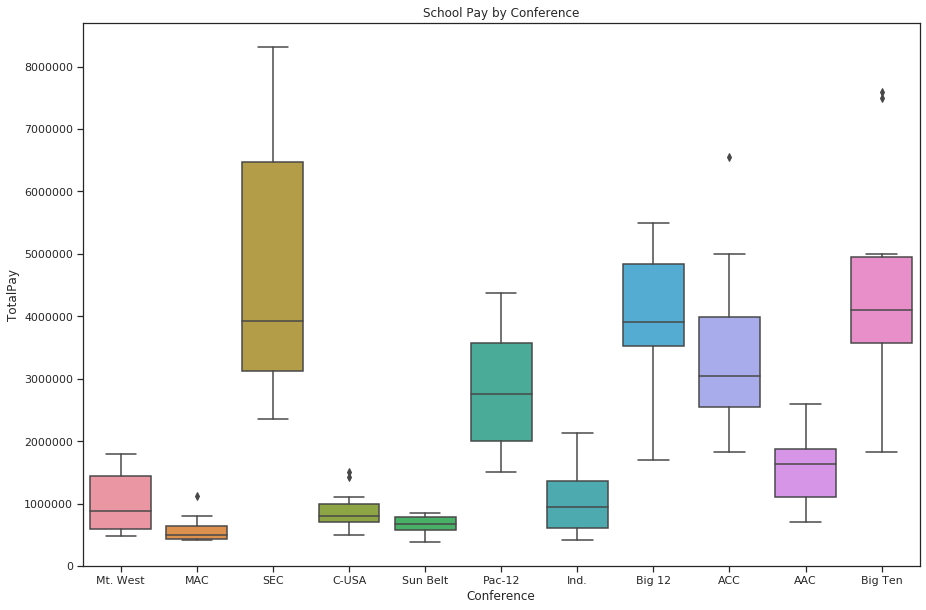

In [430]:
plt.figure(figsize=(15,10))
sns.set(style="ticks", palette="bright")
sns.boxplot(x='Conference',
               y='TotalPay', 
              data=Coaches) 
 
plt.title('School Pay by Conference')